# Player of the match classification

The goal of this project is to try to determine who the player of the match is. 

In a typical cricket match the POM is usually the batsman with the highest score, or the bowler with the highest number of wickets. Whether a player is on the winning team may also be influential, and whether a player achieves a milestone may also be of interest (ie has scored a century in an innings or taken 5 wickets in an innings).

1. Data Exploration
2. Simple Classification Model
3. Evaluation

In [1]:
%matplotlib inline
import matplotlib

#basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

sns.set(style="whitegrid")

plt.style.use('ggplot')

## 1. Data Exploration

In this section I join all three datasets together. The join is performed by player name as well as match id with the total number of wickets and runs across each innings consolodated. The identity of the player of the match

In [2]:
## load in the data

match_information = pd.read_csv(r'processed_data/match_information.csv')
batting_stats = pd.read_csv(r'processed_data/batting_stats.csv')
bowling_stats = pd.read_csv(r'processed_data/bowling_stats.csv')

In [926]:
#### Extract columns of interest and join data sets


batting_runs = batting_stats[['match_id','batsman','runs','innings','batting_team']]
bowling_wickets = bowling_stats[['match_id','bowler','wickets','innings','bowling_team']]
player_of_match = match_information[['match_id','player_of_match','player_of_match_2']]


####Batting data

# add a column for when a batsman achieves a century
batting_runs.loc[:,'century'] = batting_runs.runs >= 100


#drop the innings column
batting_runs.drop('innings', inplace=True, axis=1)


#aggregate the overall number of runs
batting_runs = batting_runs.groupby(['match_id','batsman']).agg({'runs': np.sum, 'century': np.sum, 'batting_team': 'first'})
batting_runs.reset_index(inplace=True)

####Bowling data

# add a column for when a bowler achieves a 5 wicket haul
bowling_wickets.loc[:, '5_wickets'] = bowling_wickets.wickets >= 5

#drop the innings column
bowling_wickets.drop('innings', inplace=True, axis=1)

#aggregate over the total wickets taken
bowling_wickets = bowling_wickets.groupby(['match_id','bowler']).agg({'wickets': np.sum, '5_wickets': np.sum, 'bowling_team': 'first'})
bowling_wickets.reset_index(inplace=True)

####Join batting and bowling data


player_stats = pd.merge(bowling_wickets, batting_runs, how='outer', left_on=['match_id', 'bowler'], right_on=['match_id','batsman'])



#fill empty batting/bowling teams
player_stats['bowling_team'].fillna(player_stats['batting_team'], inplace=True)
player_stats['batting_team'].fillna(player_stats['bowling_team'], inplace=True)
player_stats.drop('batting_team', inplace=True, axis=1)
player_stats.rename(columns={'bowling_team':'team'}, inplace=True)

#fill empty bowling/batting player name
player_stats['bowler'].fillna(player_stats['batsman'], inplace=True)
player_stats['batsman'].fillna(player_stats['bowler'], inplace=True)
player_stats.drop('batsman', inplace=True, axis=1)
player_stats.rename(columns={'bowler': 'player'}, inplace=True)


winners = match_information[['match_id','winner']]
player_stats = pd.merge(player_stats, winners, how='left', on='match_id')
player_stats['winner'].fillna('draw', inplace=True)

#add categorical for wins losses and draws
filter_wins = player_stats['winner'] == player_stats['team']
filter_draws = player_stats['winner'].isin(['draw'])
filter_losses = ~(filter_wins | filter_draws) #losses are not wins or draws

player_stats['wld'] = ""
player_stats.loc[filter_wins,'wld'] = 'win'
player_stats.loc[filter_draws,'wld'] = 'draw'
player_stats.loc[filter_losses,'wld'] = 'loss'

player_stats['wld'] = player_stats['wld'].astype('category')


#append the player of the match
player_of_match = match_information[['match_id','player_of_match','player_of_match_2']]
#append the player of the match to each match

player_stats = pd.merge(player_stats, player_of_match, how='left', on=['match_id'])
#check player of the match against player names

#player_stats['POM'] = (player_stats.player == player_stats.player_of_match) | (player_stats.player == player_stats.player_of_match_2)
player_stats['POM'] = (player_stats.player == player_stats.player_of_match)#ignore 2nd POMs
player_stats.drop(['player_of_match','player_of_match_2'], inplace=True, axis=1)

# fill in NaN values with zero (ie if a player didn't bat or bowl their contribution is 0 runs or wickets)
player_stats['wickets'].fillna(0, inplace=True)
player_stats['5_wickets'].fillna(0, inplace=True)
player_stats['runs'].fillna(0, inplace=True)
player_stats['century'].fillna(0, inplace=True)
player_stats['wld'].fillna('draw') #set match result to neutral 'draw' if result is unknown



''

#### Rescale Runs and Wickets 

In this section I rescale the runs and wickets for each player by the number of wickets or runs in the match. The player of the match is then replotted

Generate a strip plot of wickets and runs colored by POM


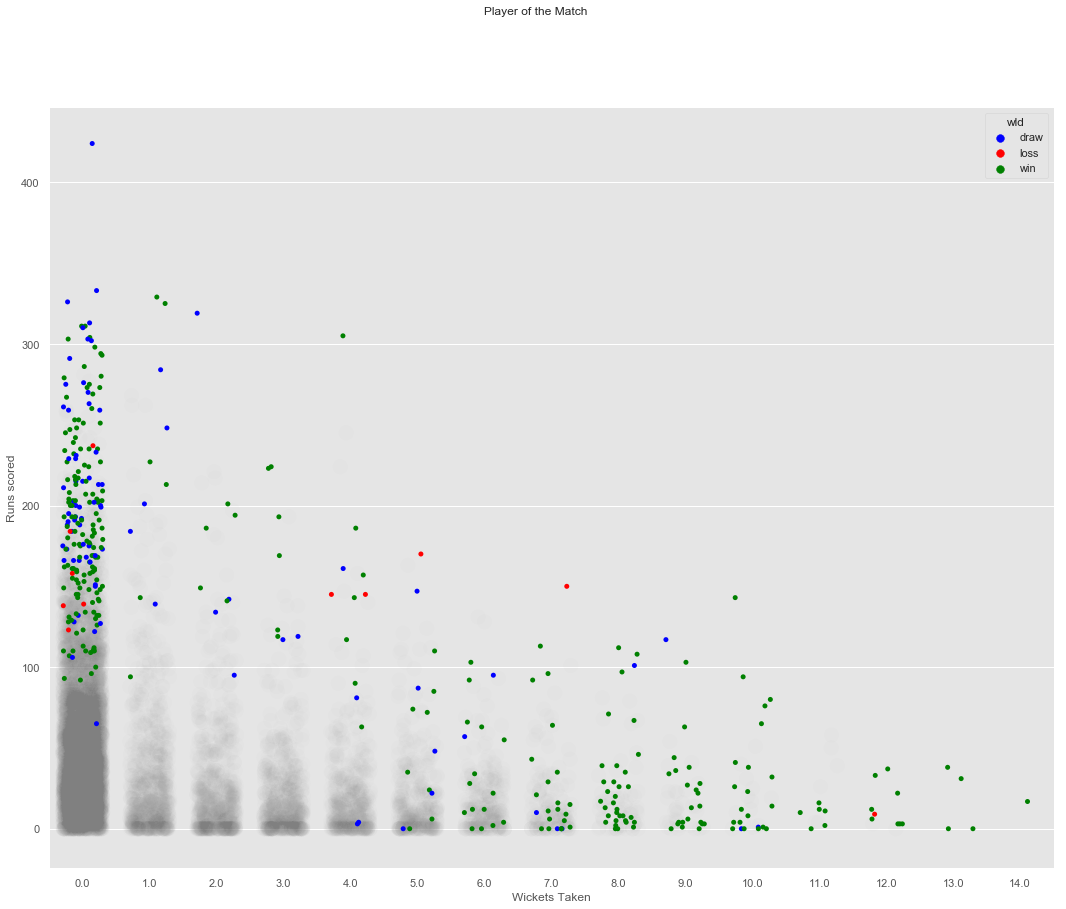

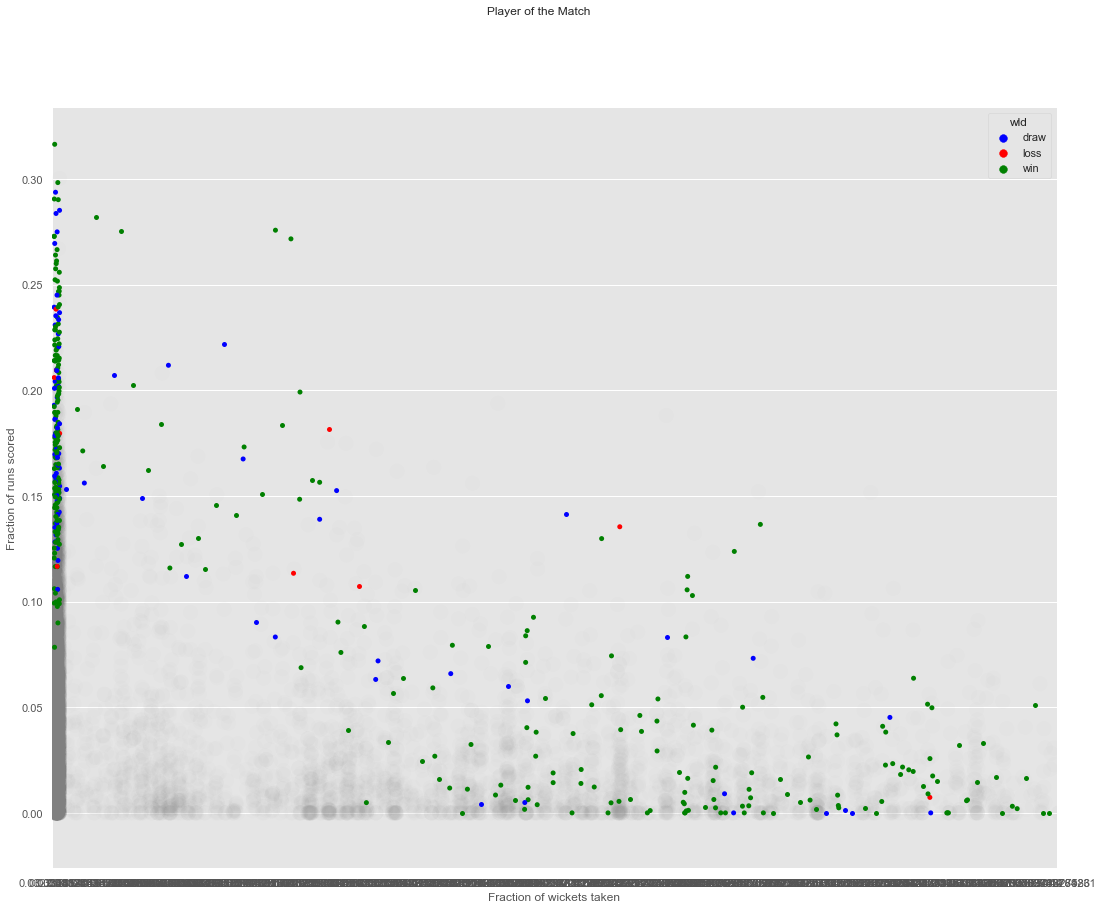

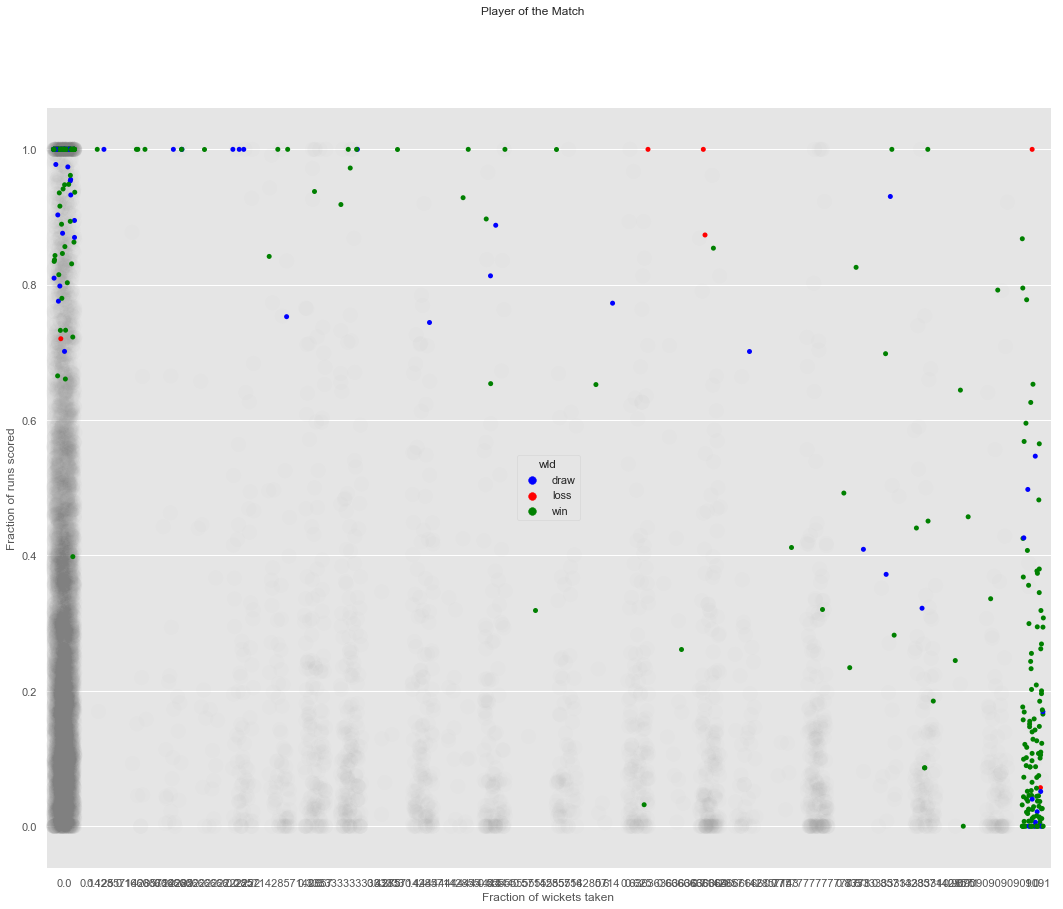

In [1039]:

#Find the number of wickets and the number of runs for each match

match_runs_wickets = player_stats[['match_id','runs','wickets']].groupby('match_id').sum()
match_runs_wickets.reset_index(inplace=True)
match_runs_wickets.rename(columns={'runs':'match_runs', 'wickets':'match_wickets'}, inplace=True)

player_stats2 = pd.merge(player_stats, match_runs_wickets, how='left', on='match_id')

player_stats2['runs_fraction'] = player_stats2['runs'] / player_stats2['match_runs']
player_stats2['wickets_fraction'] = player_stats2['wickets'] / player_stats2['match_wickets']

#Find the maximum run scorer for each match
top_match_scorer = player_stats[['match_id','runs']].groupby('match_id').max()
top_match_scorer.rename(columns={'runs':'top_runs'}, inplace=True)

player_stats2 = pd.merge(player_stats2, top_match_scorer, how='left', on='match_id')
player_stats2['top_runs_frac'] = player_stats2['runs'] / player_stats2['top_runs']

#Find maximum wicket taker for each match
top_wicket_taker = player_stats[['match_id','wickets']].groupby('match_id').max()
top_wicket_taker.rename(columns={'wickets':'top_wickets'}, inplace=True)

player_stats2 = pd.merge(player_stats2, top_wicket_taker, how='left', on='match_id')
player_stats2['top_wickets_frac'] = player_stats2['wickets'] / player_stats2['top_wickets']




#eliminate matches without a POM
match_agg = player_stats2[['match_id','POM']].groupby(['match_id']).sum()
list_pom = match_agg.loc[match_agg['POM'] == True].reset_index()

list_pom = list_pom['match_id'].tolist()

pom_matches = player_stats2[player_stats2['match_id'].isin(list_pom)]





print('Generate a strip plot of wickets and runs colored by POM')

#split data into players of the match and not players of the match
pom = pom_matches.loc[player_stats['POM'] == True]
npom = pom_matches.loc[player_stats['POM'] == False]



#plot a scatterplot of runs and wickets coloured by POM
fig, ax1 = plt.subplots(1,1, figsize=(18,14))
sns.stripplot(x = 'wickets', y = 'runs', data=npom,color='gray', alpha=0.02, jitter=0.3, s=15)
pal = ['blue','red','green']
sns.stripplot(x = 'wickets', y = 'runs',hue='wld',palette=pal, data=pom, alpha=1, jitter=0.3)
#sns.boxplot(x = 'wickets', y = 'runs', data=npom)
fig.suptitle('Player of the Match')
plt.xlabel('Wickets Taken')
plt.ylabel('Runs scored')
plt.show()


#plot a scatterplot of normalized runs and wickets coloured by POM
fig, ax2 = plt.subplots(1,1, figsize=(18,14))
sns.stripplot(x = 'wickets_fraction', y = 'runs_fraction', data=npom,color='gray', alpha=0.02, jitter=0.3, s=15)
pal = ['blue','red','green']
sns.stripplot(x = 'wickets_fraction', y = 'runs_fraction',hue='wld',palette=pal, data=pom, alpha=1, jitter=0.3)
#sns.boxplot(x = 'wickets', y = 'runs', data=npom)
fig.suptitle('Player of the Match')
plt.xlabel('Fraction of wickets taken')
plt.ylabel('Fraction of runs scored')
plt.show()


#plot a scatterplot of normalized runs and wickets coloured by POM
fig, ax3 = plt.subplots(1,1, figsize=(18,14))
sns.stripplot(x = 'top_wickets_frac', y = 'top_runs_frac', data=npom,color='gray', alpha=0.02, jitter=0.3, s=15)
pal = ['blue','red','green']
sns.stripplot(x = 'top_wickets_frac', y = 'top_runs_frac',hue='wld',palette=pal, data=pom, alpha=1, jitter=0.3)
#sns.boxplot(x = 'wickets', y = 'runs', data=npom)
fig.suptitle('Player of the Match')
plt.xlabel('Fraction of wickets taken')
plt.ylabel('Fraction of runs scored')
plt.show()

### 1.1 Remarks

The strip plot of the runs and wickets taken by players has been colored by whether or not a player was awarded the player of the match. This is further broken down into whether the players team won, lost or the match resulted in a draw.

As we might expect the vast majority of the POM awards went to players who were part of the winning team. There is a bias towards this result because a POM may boost their teams chances of winning. There is also the phychological factor which gives players on a winning side an extra advantage. If two players on opposing teams perform similarly the deciding factor is usually governed by which team won.

In terms of the number of runs earned and the number of wickets taken there appears to be a fairly smooth tradeoff. An excellent bowling performance (8 or more wickets) is usually enough to be awarded POM even if the number of runs earned is quite low. Similarly a batsman who does not even bowl is usually awarded POM if they score above 200 runs in the match. 

The POM awards which went to the lowest number of runs or wickets taken are all from drawn matches and I speculate that this is because the match was cut short due to rain delays or similar events. Due to this a large number of wickets or runs could not be accumulated in the reduced match time.

When normalized for the number of runs and wickets in a match there are fewer POM outliers which appear to fall within the normal (non POM) range of scores.


## 2. Creating A Classification Model


Now that we have an idea what the data looks like we can create a classification model for these data. 

Features: wickets, 5_wickets, runs, century, wld
Target: POM (boolean)

Rather than assigning predictions to each player I assign a probability of the player being a POM. This is because POM occurs once each match (with a few exceptions). The most likely player of the match is then the player assigned the highest probability within a given match_id bracket, regardless of the absolute value. 



#### 2.1 Simple model

Using only the runs scored, wickets taken, and whether the player was on the winning team I create a model to predict the player of the match.

In [1068]:
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC

######################

#display(matches_without_pom.loc[matches_without_pom['POM']==False])

features = pom_matches.loc[:,['wickets','runs','century','5_wickets','wld','runs_fraction','wickets_fraction','top_wickets_frac','top_runs_frac']]
#features = pom_matches.loc[:,['wickets','runs','century','5_wickets','wld','top_runs_frac','top_wickets_frac']]
features = pom_matches.loc[:,['wickets','runs','century','5_wickets','wld','wickets_fraction','runs_fraction']]



features['wld'] = pom_matches['wld'].astype('str')
features.loc[features['wld'] == 'win', 'wld'] = 1 #1 unit for a win
features.loc[features['wld'] == 'loss', 'wld'] = -1 #-1 units for a loss
features.loc[features['wld'] == 'draw', 'wld'] = 0 #0 units for a draw


##apply a standard scaler
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(features)

#designate targets
targets = pom_matches['POM']

## Principle component analysis
from sklearn.decomposition import PCA
n_components = 4

pca = PCA(n_components = n_components)
principle_components = pca.fit_transform(scaled_features)


#apply a classifier
clf = OneVsRestClassifier(LinearSVC(random_state=42, max_iter=10000)).fit(principle_components, targets)

distance = clf.decision_function(principle_components)


#generate a dataframe pc_stats containing player and match names, POM tag, and player score
#player score is a measure of distance above or below the classification line
#sort each player within a match by this score and assign a match ranking

pc_stats = pom_matches[['match_id','player','POM']]
pc_stats['score'] = distance
pc_stats.sort_values(['match_id','score'], ascending=[True, False], inplace=True)#.reset_index(drop=True)
pc_stats.reset_index(inplace=True, drop=True)

pc_stats['match_rank'] = pc_stats.groupby('match_id').cumcount() + 1



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.

In [1069]:
#add a column for naive_POM which takes any score above 0 as POM
# This is naive because it does not take into accound multiple >0 scores in a single match, or none
pc_stats['naive_POM'] = pc_stats[['score']] > 0



#find values for a confuction matrix

from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(pc_stats[['POM']], pc_stats[['naive_POM']]).ravel()

print('naive approach')
print('true neg = {}, false pos={}, false neg={}, true pos={}'.format(tn,fp,fn,tp) )

#so the naive approach seems to be a poor estimator of player of the match
# it correctly identifies 90 POM, but fails to identify 312 players of the match.
#we can improve this result by finding how many players with match rank 1 are also POM

tn, fp, fn, tp = confusion_matrix(pc_stats[['POM']], pc_stats[['match_rank']] == 1).ravel()

print('ranked approach')
print('true neg = {}, false pos={}, false neg={}, true pos={}'.format(tn,fp,fn,tp) )



naive approach
true neg = 8376, false pos=41, false neg=258, true pos=144
ranked approach
true neg = 8301, false pos=116, false neg=116, true pos=286


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## 3. Evaluation 

In the previous section I train a model on the player of the match data an naively interpret the predicted 'POM' tags as the true player of the match. The problem with this approach is that it does not guarantee a single POM for each match.

In this section I will attempt to provide a better evaluation of the model which relies on assinging player of the match to the player who is most above (or closest to) the decision boundary. This distance will be known as the score. A positive score corresponds to a datapoint within the POM region, while a negative score is below this threshold.

For exceptional games there may be many players with positive scores, and I set the player with the highest score to be player of the match. Similarly with a poor match it is possible that no player has a score above 0. In this case the player with the highest score is awarded player of the match.



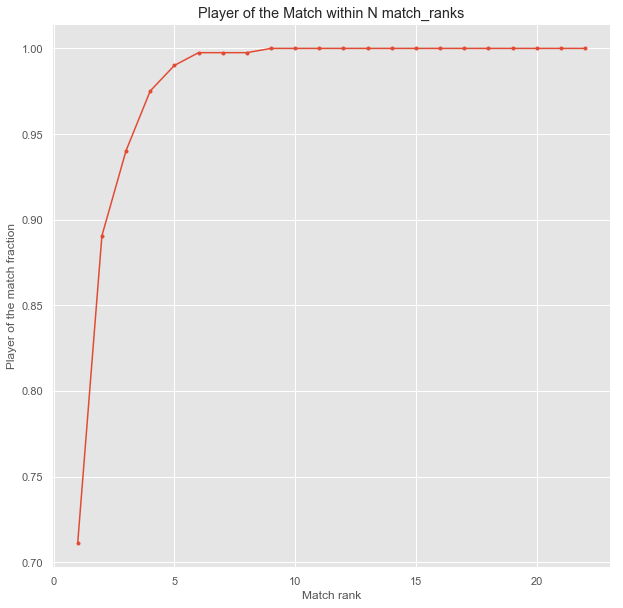

97.51243781094527% of player of the player of the match awards lie within 4 match_ranks.
Top score is POM 71.14427860696517% of the time.


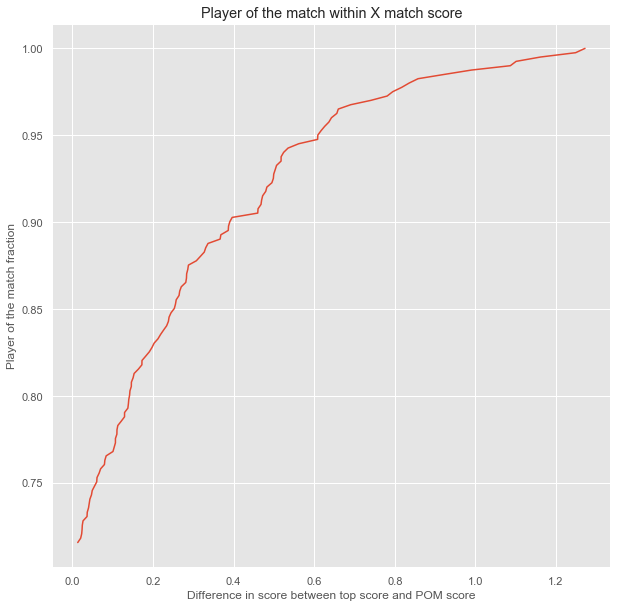

95% of player of the player of the match awards lie within 0.6644590577005667 score.


In [1070]:
## plot the accuracy of determining Player of the Match in terms of 'match_ranks' and 'score'

true_pos = np.zeros(22)
for t in range(1,23):
    _, _, _, tp = confusion_matrix(pc_stats[['POM']], pc_stats[['match_rank']] <= t).ravel()
    true_pos[t-1] = tp

    
true_pos_frac = true_pos / (pc_stats[['POM']].sum()[0])



#plot fraction of player of the match within N match_ranks

#plot a lineplot of the results
fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.plot(list(range(1,23)), true_pos_frac, marker='.')
ax.set_title('Player of the Match within N match_ranks')
ax.set_xlabel('Match rank')
ax.set_ylabel('Player of the match fraction')

plt.show()



print('{}% of player of the player of the match awards lie within 4 match_ranks.'.format(true_pos_frac[3]*100))
print('Top score is POM {}% of the time.'.format(true_pos_frac[0]*100))




#plot another linesplot in terms of POM accuracy vs distance from best match_rank
#get both the best match_rank from each match, then get the match_rank of the corresponding POM

#return list of players of the match
pom_list = pc_stats.loc[pc_stats['POM']==True] 
pom_list.reset_index(inplace=True)
pom_list = pom_list.score
best_scores_list = pc_stats[['score','match_id']].groupby(['match_id']).max() #sorted by highest score first
best_scores_list.reset_index(inplace=True)
best_scores_list = best_scores_list.score

delta_list = pom_list - best_scores_list


delta_sorted = -delta_list.sort_values(ascending=False)
n = delta_list.shape[0] #number of elements
delta_frac = np.linspace(0,1,n)
delta = pd.DataFrame({'delta_frac': delta_frac, 'delta_sorted': delta_sorted})
delta.reset_index(inplace=True, drop=True)

delta = delta.loc[delta['delta_sorted'] > 0] #truncate out differences of 0


#plot a lineplot of the results
fig, ax2 = plt.subplots(1,1, figsize=(10,10))
plt.plot(delta.delta_sorted, delta.delta_frac)

ax2.set_title('Player of the match within X match score')
ax2.set_ylabel('Player of the match fraction')
ax2.set_xlabel('Difference in score between top score and POM score')

plt.show()

within95 = -comp_list.loc[comp_list['frac'] > 0.95].iloc[0]['score_delta']
print('95% of player of the player of the match awards lie within {} score.'.format(within95))


This model is able to determine the player of the match with 71% accuracy. The POM is chosen from the top 4 scored players 97.58% of the time.


#### Decision Boundary

In the following cell I plot the scaled fraction of match runs and fraction of match wickets of each player of the match as well as a decision boundary of a simple SVM classifier on this data.

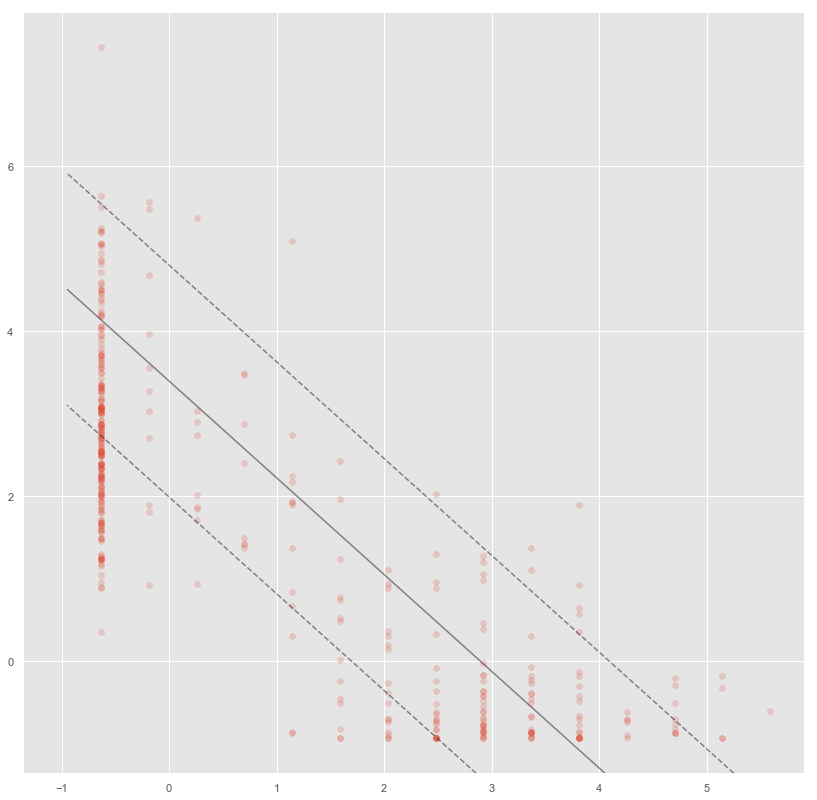

In [1036]:
features_ = pom_matches.loc[:,['runs_fraction','wickets_fraction']]
#features = pom_matches.loc[:,['century','5_wickets','wld','runs_fraction','wickets_fraction']]

##apply a standard scaler
from sklearn.svm import SVC
scaled_features_ = StandardScaler().fit_transform(features_)

clf_ = SVC(random_state=42, max_iter=10000, kernel='linear').fit(scaled_features_, targets)


fig, ax6 = plt.subplots(1,1, figsize=(14,14))

plt.scatter(x = scaled_features[pom_matches['POM'] == True,0], y = scaled_features[pom_matches['POM'] == True,1], alpha=0.2)


# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = clf_.decision_function(xy).reshape(XX.shape)
# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none')
plt.show()

Note that the decision boundary above is for a simplified model which considers only fraction of runs earned and wickets taken. Only player of the match datapoints are shown, and non POMs are not shown. Note that the decision boundary actually seems to exclude more POMs than it includes. This is because there is approximatly 20 times more non-POMs that POMs which skews the decision boundary to and extreme where player of the matches become more numerous than non player of the matches.



#### More Complex model

From the results of the simple model the player of the match only corresponds with the first ranked player around 65% of the time. I hypothesise that this may be because of a few factors. 

Psychology: 

In cricket there are 'milestones' for batsmen and bowlers. A player who scores 100 runs or a century is regarded as having played a good innings. While a player who scores 101 runs may not significantly contribute more than a player who scores 99 runs there is some elevated status which is given to a player that breaks the 100 run milestone.

Similarly for bowlers anyone who takes 5 wickets in an innings is highly regarded as having bowled well. This venerable status is probably less psychologically impactful than a batsman scoring a century. This is because someone taking 5 wickets is significantly better than someone taking only 4, whereas someone scoring 101 runs is not significantly better than someone scoring 99.

Impact: 

Another important factor when determining whether a player is awarded POM is how impactful their innings was. If for example a bowler takes the wickets of good batsmen, then they may be considered more impactful than a bowler who takes the wickets of poor batsmen.